# Physics 210 Project 1: "How can colliding with the slime planet save the spaceship from a black hole?"

**Name:** Mufaro Joseph Machaya

## Introduction

**Context:** Given a three-body system containing a black hole (with a mass $M$), a small planet made of JELL-O-like slime (with mass $m_p$), and a spaceship (with mass $m_s$) accidentally headed directly for the black hole, the only way for the spaceship to avoid being sucked into the black hole is to turn into and collide (inelastically) with the planet such that it is successfully rebounded with a velocity high enough to escape the gravitational pull of the black hole. However, if it hits the planet with too much impulse during the collision, it'll be destroyed by the planet (it's made out of JELL-O, so it has surface tension). 

**Research Question:** *With what range of initial velocities and what turn radius/time allow the ship to successfully avoid being sucked into the black hole without being destroyed by the planet?*

### Physics Model and Assumptions

**Model**

1. $n$-Body System, Gravitational Vector Field

Each of the three objects are modeled individually as point-masses. Each object produces gravitational effects on all other objects by formula

$${\bf F}_g = G \frac{m_1 m_2}{|{\bf r}|^2} \hat{r}.$$

From there, basic kinematic equations apply:

$$\frac{d^2 \bf{x}}{dt^2} = \frac{\sum \bf F}{m}.$$

The system is modeled in only two dimensions rather than three (but all equations apply for each dimension)

2. Spaceship Turning

The ship will need to perform a turn of angle $\theta$ to have a proper head-on collision. This will require the ship to apply thrust to perform the turn, but this turn will require a certain amount of energy. Let's assume that the ship starts with a certain amount of fuel on board (but it will require fuel to accelerate/deccelerate during its journey).

The ship turns with thrust

$${\bf T} = {\bf v} \frac{dm}{dt}$$

3. Inelastic Jello Collision

The force from interacting with a gel-like substance will be modeled using a hunt-crossley algorithm with optional adhesion and a plastic offset, i.e.,

- Contact when the overlap distance $\delta > 0$, and the force for each frame is $$F_N = k \delta^n + \alpha \delta^n \frac{d \delta}{dt},$$ with $n=\frac{3}{2}$ for spherical geometry (and $\delta = R_1 + R_2 - |\vec{r}_1 - \vec{r}_2|$)

4. Propagation by Fuel

The ship requires fuel to run.

**Additional Physics**

This system includes an inelastic collision, a gravitational vector field, and thrust equations. 

**Assumptions**

1. $m_s < m_p <<< M$: The mass of the black hole is so much larger than the mass of the planet and ship that the black hole is taken to be stationary.
2. This model assumes no relativistic effects whatsoever (due to all speeds $v$ being much lower than the speed of light $c$.
3. The ship is presumed to instantaneously make a full $180^\circ$ turn immediately after its collision.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from dataclasses import dataclass
from copy import deepcopy
import io
from typing import override
from PIL import Image
from IPython.display import HTML
import tempfile
import time

**Code Block Summary** This is just a simple functions for calculating a unit vector, by $$\hat{\bf u} = \frac{\vec{\bf u}}{|\vec{\bf u}|}$$
for getting all of the magnitudes for a list of vectors, like
$$\text{mag}(\{\mathbf{v}_1, \mathbf{v}_2, \dots, \mathbf{v}_n \}) = \{ |\mathbf{v}_1|, |\mathbf{v}_2|, \dots, |\mathbf{v}_n| \},$$
and for rotating a vector by
$$\mathbf{R}(\mathbf{v},\theta) = \begin{pmatrix} \cos \theta & -\sin \theta \\ \sin \theta & \cos \theta \end{pmatrix} \begin{pmatrix} v_x \\ v_y \end{pmatrix}$$

In [2]:
def unit_vector(v):
    return np.array(v) / np.linalg.norm(v)

def magnitudes(vector_list):
    return [np.linalg.norm(vec) for vec in vector_list]

def rotate_vector_2d(vec, theta):
    rotation_matrix = \
        np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    return rotation_matrix @ vec

**Code Block Summary:** This code block implements in the rigid and soft bodies used for simulation. `RigidBody`-ies come with an assumption of being a point-mass, so they don't hold a radius (or any other size), but they're the base object in this simulation, with tracker arrays for each of various simulation variables tied to the object (like position, velocity, acceleration, and whatnot).

In [3]:
@dataclass
class RigidBody:
    initial_position:     float = 0
    initial_velocity:     float = 0
    initial_acceleration: float = 0
    
    mass:  float = 1
    color: str   = None
    name:  str   = None

    stationary: bool = False 
    
    position:     np.array = None
    velocity:     np.array = None
    acceleration: np.array = None
    force:        np.array = None
    energy:       np.array = None
    momentum:     np.array = None
    
    def init(self, n):
        self.position     = np.zeros((n,2))
        self.velocity     = np.zeros((n,2))
        self.acceleration = np.zeros((n,2))
        self.force        = np.zeros((n,2))
        self.energy       = np.zeros((n,2))
        self.momentum     = np.zeros((n,2))
        
        self.position[0,:]     = self.initial_position
        self.velocity[0,:]     = self.initial_velocity
        self.acceleration[0,:] = self.initial_acceleration
        
    def __hash__(self):
        return hash(self.name)
        
    def distance_vec(self, other_body, i):
        if other_body.position is None:
            print(other_body.name)
        return self.position[i] - other_body.position[i]

    def collided_with(self, other_body, i, collision_radius=0.1):
        return np.linalg.norm(self.distance_vec(other_body, i)) <= collision_radius
    
    def near_barrier(self, bottom_barrier, top_barrier, collision_radius, i):
        return \
            abs(self.position[i] - bottom_barrier) <= collision_radius or \
            abs(self.position[i] - top_barrier) <= collision_radius
    
@dataclass
class Spaceship(RigidBody):
    initial_fuel_mass:   float = 0
    turning_angle:       float = 0
    specific_impulse:    float = 0
    desired_thrust_mag:  float = 0
    
    remaining_fuel_mass: np.array = None
    thrust_dir:          np.array = None 
    
    @override
    def init(self, n):
        super().init(n)
        self.remaining_fuel_mass = np.zeros(n)
        self.thrust_dir = rotate_vector_2d(unit_vector(self.initial_velocity), self.turning_angle)
    
@dataclass
class SoftBody(RigidBody):
    radius:          float = 0
    stiffness:       float = 0
    growth_exponent: float = 0
    damping_coeff:   float = 0

**Code Block Summary:** This is where the thrust calculations come in. The space ship has a certain amount of fuel, `remaining_fuel_mass`, in kilograms of burnable fuel (which is approximately reliably converted into energy at a set rate). The instantaneous thrust force produced is
$${\bf F}_{thrust}(t) = T(t) \hat{\bf u}(t),$$
where $T(t)$ is the magnitude of thrust at $t$ and $\hat{\bf u}(t)$ is the direction of thrust. The magnitude of thrust for a given $t$ is
$$T(t) = \left| \frac{dm_{f}}{dt}\right| {v}_{ex},$$
where $m_f$ is the mass of the remaining fuel and ${v}_ex$ is the exhaust velocity given by
$${v}_{ex} = I_{sp} g_0$$
where $I_{sp}$ is the specific impulse [1](https://en.wikipedia.org/wiki/Specific_impulse) and $g_0$ is the standard gravity [2](https://en.wikipedia.org/wiki/Standard_gravity).

In [4]:
STANDARD_GRAVITY = 9.80665

def calculate_thrust(ship, dt):
    # force normalize thrust direction
    ship.thrust_dir = ship.thrust_dir / np.linalg.norm(ship.thrust_dir)
    # set the wanted thrust magnitude
    thrust_mag = np.max(0, ship.desired_thrust_mag)
    
    if thrust_mag <= 0:
        return np.zeros(2), 0.0
    
    exhaust_speed = specific_impulse * STANDARD_GRAVITY
    required_mass_deriv = desired_thrust / exhaust_velocity
    required_mass = required_mass_deriv * dt

    # limit by available fuel
    if required_mass > ship.remaining_fuel_mass:
        required_mass = ship.remaining_fuel_mass
        required_mass_deriv = required_mass / dt
        thrust_mag = required_mass_deriv * exhaust_speed
        
    thrust_force_vector = ship.thrust_dir * thrust_mag
    return thrust_force_vector, required_mass

**Code Block Summary:** This is where the gravitational force between two objects is calculated with
$${\bf F}_g = G \frac{m_1 m_2}{|{\bf r}|^2} \hat{r}$$
for each object with mass $m_1$ to each other object with mass $m_2$, given a radial distance $\bf r$ between them.

In [5]:
GRAVITATIONAL_CONSTANT = 6.6743e-11

def calculate_gravitational_force(last_frame, body, other):
    displacement = body.distance_vec(other, last_frame)
    distance     = np.linalg.norm(displacement)
    if distance == 0:
        return 0
    direction    = displacement / distance

    return (GRAVITATIONAL_CONSTANT * body.mass * \
             other.mass * direction) / distance ** 2

**Code Block Summary:** This is where the normal force during the inelastic collision between the spaceship and the slime planet (in the case that it happens) is calculated by the Hunt-Crossley non-linear contact model [3](https://doi.org/10.1115/1.3423596)
$${\bf F}_N = k \delta^n + \alpha \delta^n \frac{d \delta}{dt},$$ with $n=\frac{3}{2}$ for spherical geometry (and $\delta = R_1 + R_2 - |\vec{r}_1 - \vec{r}_2|$, but due to point-like approximations, only the slime planet has a radius).

In [6]:
def calculate_soft_body_collision_normal_force(last_frame, body, soft_body):
    # assume this object has 0 radius because
    # of pointlike approximations
    overlap = other.radius - distance
    
    if overlap > 0:
        relative_velocity = body.velocity[last_frame] - soft_body.velocity[last_frame]
        overlap_deriv = -np.dot(relative_velocity, direction)
        normal_force_mag = soft_body.stiffness * overlap ** soft_body.growth_exponent + \
            soft_body.damping_coeff * overlap ** soft_body.growth_exponent * overlap_deriv
                
        normal_force = normal_force + normal_force_mag * direction
        return normal_force
    else:
        return np.zeros(2)

**Code Block Summary:** This is where the net force is calculated as the sum of all of the gravitational forces to the other bodies, the normal force if a collision is occuring, and the thrust force (for the space ship).

In [7]:
def calculate_net_force(last_frame, body, objects, dt):
    """
    A general function for calculating the net force
    for the two moving objects in the simulation: the
    space ship and the slime planet.
    """
    
    other_objects = [x for x in objects if x is not body]
    total_force = np.zeros(2)
    
    for other in other_objects:        
        total_force = total_force + calculate_gravitational_force(last_frame, body, other)
        
        if isinstance(other, SoftBody) and body.collided_with(other, last_frame):
            normal_force = calculate_soft_body_collision_normal_force()
        
    if isinstance(body, Spaceship):
        ship = body
        thrust_force, fuel_mass_used = calculate_thrust(ship, dt)
        ship.remaining_fuel_mass[last_frame + 1] = ship.remaining_fuel_mass[last_frame] - fuel_mass_used
        total_force = total_force + thrust_force
        
    return total_force

**Code Block Summary:** These are the constant characteristics/initial parameters for the model, which are each invariant across each simulation to begin with.

*Note: right now, I've just asked ChatGPT for realistic values to put in for testing purposes. Will need to research good values later.*

In [8]:
SLIME_PLANET_INITIAL_POSITION=np.array([10,-3])
SLIME_PLANET_INITIAL_VELOCITY=unit_vector([-1,-1])*10
SLIME_PLANET_RADIUS=500 # m
SLIME_STIFFNESS=200 # N/m^n - n=3/2
SPHERICAL_GROWTH_EXPONENT=3/2
SLIME_DAMPING_COEFFICIENT=5 # ns/m^n - n=3/2

In [9]:
SPACE_SHIP_INITIAL_POSITION=np.array([15,-6])
SPACE_SHIP_INITIAL_DIRECTION=unit_vector([-1,1])
SPACE_SHIP_INITIAL_FUEL_MASS=50.0 # kg

In [10]:
BLACK_HOLE_INITIAL_POSITION=np.array([0,0])
BLACK_HOLE_MASS=1e4 # kg

**Code Block Summary:** This section produces an animation of the full simulation. It isn't the only means to verify that the simulation is working as intended, but provides a quick and easy way to check for glaring problems in the simulation.

In [11]:
def produce_animation(simulation_result):
    time_data = simulation_result.time_data
    space_ship_trajectory = simulation_result.space_ship.position
    slime_planet_trajectory = simulation_result.slime_planet.position
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)

    # scatter points for each body
    space_ship_marker,   = ax.plot([], [], 'ro', label='Spaceship')
    slime_planet_marker, = ax.plot([], [], 'go', label='Slime Planet')
    black_hole_marker,   = ax.plot([], [], 'ko', label='Black Hole')
    
    ax.legend()

    def init():
        space_ship_marker.set_data([], [])
        slime_planet_marker.set_data([], [])
        black_hole_marker.set_data([], [])
        
        return space_ship_marker, slime_planet_marker, black_hole_marker

    def update(frame):
        def set_position(marker, trajectory):
            marker.set_data([trajectory[frame,0]], [trajectory[frame,1]])
            
        set_position(space_ship_marker,   space_ship_trajectory)
        set_position(slime_planet_marker, slime_planet_trajectory)
        black_hole_marker.set_data([0],[0])
        
        return space_ship_marker, slime_planet_marker, black_hole_marker

    print('Animating simulation..')
    
    ani = FuncAnimation(fig, update, frames=len(time_data),
                        init_func=init, blit=True, interval=20)

    print('Animation complete! Writing..')
    
    start = time.time()
    result = HTML(ani.to_html5_video())
    end = time.time()
    print("Elapsed time:", end - start, "seconds")
    
    return result

**Code Block Summary:** This block plots all of the results *of a singular simulation*: keeping track of the position (measured as the scalar distance to the black hole), speed, acceleration, kinetic energy, momentum, and remaining fuel mass.

In [12]:
@dataclass
class SimulationPlots:
    distance_graph:       Image = None
    speed_graph:          Image = None
    kinetic_energy_graph: Image = None
    speed_graph:          Image = None
    momentum_graph:       Image = None
    
def plot_results(angle, initial_speed, time_data, slime_planet, space_ship, black_hole, animate_results):
    def save_graph_and_close():
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        graph = Image.open(buf)
        plt.close()
        return graph

    def set_axes(variable_name, units):
        plt.xlabel('Time (s)')
        plt.ylabel(f'{variable_name} ({units})')
        plt.title(f'Sim. ($θ={angle:.1f},v_0={initial_speed:.1f}$) - {variable_name} vs Time')
        plt.legend()
    
    plots=SimulationPlots()
    
    # distance to the black hole (0,0)
    plt.figure()
    plt.plot(time_data, magnitudes(space_ship.position),   label='Space Ship')
    plt.plot(time_data, magnitudes(slime_planet.position), label='Slime Planet')
    set_axes('Radial Distance','m')
    plots.distance_graph = save_graph_and_close()
    
    # velocity
    plt.figure()
    plt.plot(time_data, magnitudes(space_ship.velocity),   label='Space Ship')
    plt.plot(time_data, magnitudes(slime_planet.velocity), label='Slime Planet')
    set_axes('Speed', 'm/s')
    plots.speed_graph = save_graph_and_close()
    
    # kinetic energy
    plt.figure()
    plt.plot(time_data, space_ship.kinetic_energy,   label='Space Ship')
    plt.plot(time_data, slime_planet.kinetic_energy, label='Slime Planet')
    plt.plot(time_data, space_ship.kinetic_energy + slime_planet.kinetic_energy, label='Total')
    set_axes('Kinetic Energy', 'J')
    plots.kinetic_energy_graph = save_graph_and_close()

    # momentum
    plt.figure()
    plt.plot(time_data, space_ship.momentum,   label='Space Ship')
    plt.plot(time_data, slime_planet.momentum, label='Slime Planet')
    plt.plot(time_data, space_ship.momentum + slime_planet.momentum, label='Total')
    set_axes('Momentum', 'kg*m/s')
    plots.momentum_graph = save_graph_and_close()

    return plots

**Code Block Summary:** This code runs the full simulation for one combination pair of a spaceship turning angle $\theta$ and an initial speed $v_0$. At every moment, it calculates the acceleration for each moving object then updates all lower differentials accordingly.

In [13]:
@dataclass
class SimulationResult:
    time_data:      np.array
    space_ship:     Spaceship
    black_hole:     RigidBody
    slime_planet:   SoftBody
    visualizations: SimulationPlots

def simulate(time_range, dt, angle, initial_speed, animate_results=False):
    time_data = np.arange(time_range[0], time_range[1], dt)
    total_frames = np.size(time_data)
    
    black_hole = RigidBody(
        initial_position=BLACK_HOLE_INITIAL_POSITION,
        position=np.repeat(BLACK_HOLE_INITIAL_POSITION,total_frames),
        mass=BLACK_HOLE_MASS,
        name='Black Hole'
    )

    space_ship = Spaceship(
        initial_position=SPACE_SHIP_INITIAL_POSITION,
        initial_velocity=SPACE_SHIP_INITIAL_DIRECTION * initial_speed,
        turning_angle=angle,
        initial_fuel_mass=SPACE_SHIP_INITIAL_FUEL_MASS,
        name='Space Ship'
    )

    slime_planet = SoftBody(
        initial_position=SLIME_PLANET_INITIAL_POSITION,
        initial_velocity=SLIME_PLANET_INITIAL_VELOCITY,
        radius=SLIME_PLANET_RADIUS,
        stiffness=SLIME_STIFFNESS,
        growth_exponent=SPHERICAL_GROWTH_EXPONENT,
        damping_coeff=SLIME_DAMPING_COEFFICIENT,
        name='Slime Planet'
    )
    
    space_ship.init(total_frames)
    slime_planet.init(total_frames)
    
    interval = total_frames // 10
    for i in range(1, total_frames):
        if i % interval == 0:
            print(f'{(i / total_frames) * 100:.0f}% - Iteration {i}/{total_frames}')
        for body in [space_ship, slime_planet]:       
            body.position[i]     = body.position[i-1] + body.velocity[i-1]     * dt
            body.velocity[i]     = body.velocity[i-1] + body.acceleration[i-1] * dt
            body.force[i]        = calculate_net_force(i-1, body, [space_ship, slime_planet, black_hole], dt)
            body.acceleration[i] = body.force[i] / body.mass
            
    # ending calculations
    for body in [space_ship, slime_planet]:
        body.momentum = body.mass * abs(body.velocity)
        body.kinetic_energy = (1/2) * body.mass * body.velocity ** 2
        
    plots = plot_results(angle, initial_speed, time_data, slime_planet, space_ship, black_hole, animate_results)
        
    return SimulationResult(
        time_data=time_data,
        slime_planet=slime_planet,
        space_ship=space_ship,
        black_hole=black_hole,
        visualizations=plots
    )

**Code Block Summary:** This function performs all of the simulations by running the above function across a range of initial angles and initial speeds, producing an associative list mapping the angle/speed pairs to the results of its simulation.

In [14]:
def simulate_all(time_range, dt, angle_range, speed_range):
    """
    Performs all simulations within the angle and speed range, 
    then returns a dictionary mapping the angle/speed pairs to
    the results of a given simulation.
    """
    results = dict()
    
    for angle in np.linspace(angle_range[0], angle_range[1], num=angle_range[2]):
        for speed in np.linspace(speed_range[0], speed_range[1], num=speed_range[2]):
            results[(angle,speed)] = simulate(time_range, dt, angle, speed)
            
    return results

**Code Block Summary:** This code block sets up the basic conditions for each of the objects in our simulation. The situation at hand looks like the following:

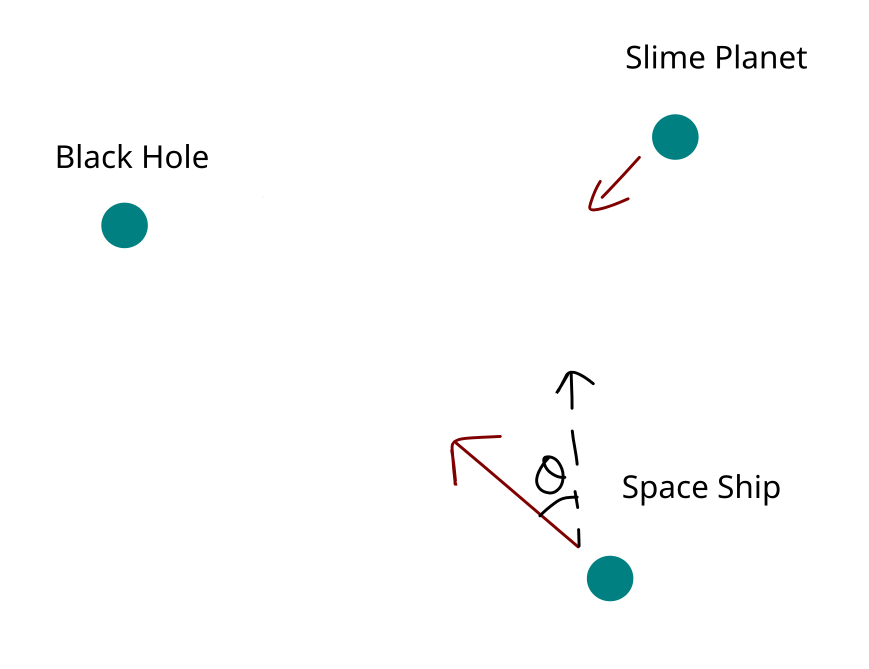

(although, not to scale). *Note to self: remove the figure above! Not to end up in the final draft!!*

In [15]:
"""
simulate_all(time_range=(0, 100), dt=0.01,
             angle_range=(-np.pi/2, np.pi/2,10),
             speed_range=(100,1000,10))
"""

'\nsimulate_all(time_range=(0, 100), dt=0.01,\n             angle_range=(-np.pi/2, np.pi/2,10),\n             speed_range=(100,1000,10))\n'

In [16]:
test = simulate(time_range=(0,100), dt=0.01, 
                angle=np.pi/4, initial_speed=10, animate_results=True)

10% - Iteration 1000/10000
20% - Iteration 2000/10000
30% - Iteration 3000/10000
40% - Iteration 4000/10000
50% - Iteration 5000/10000
60% - Iteration 6000/10000
70% - Iteration 7000/10000
80% - Iteration 8000/10000
90% - Iteration 9000/10000


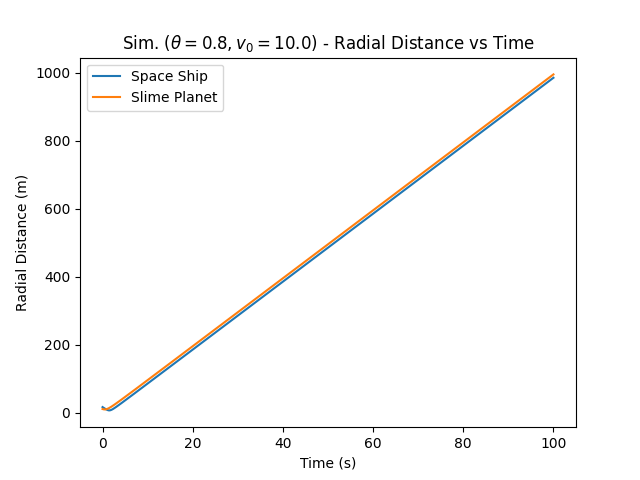

In [17]:
display(test.visualizations.distance_graph)

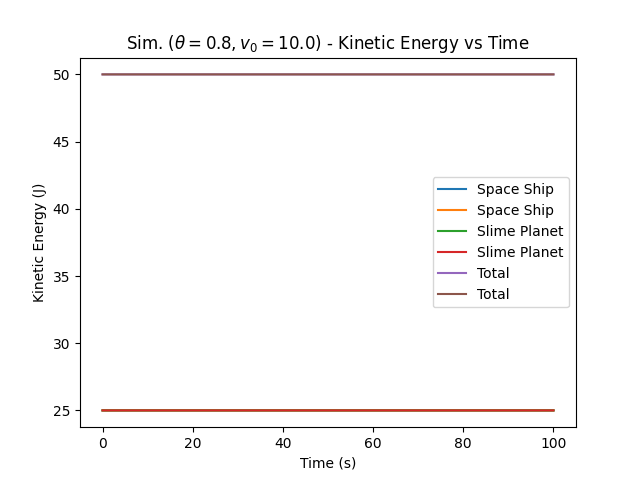

In [18]:
display(test.visualizations.kinetic_energy_graph)

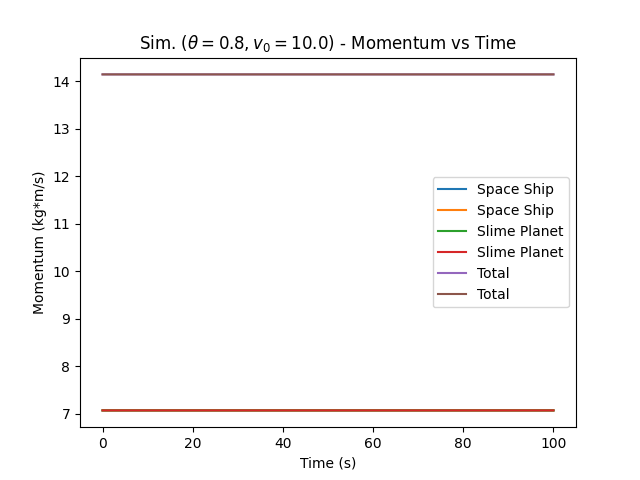

In [19]:
display(test.visualizations.momentum_graph)

Animating simulation..
Animation complete! Writing..
Elapsed time: 364.7251727581024 seconds


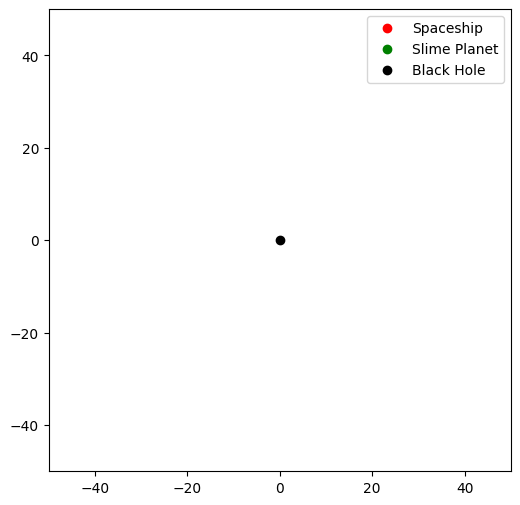

In [20]:
produce_animation(test)

### Bibliography

[1] https://en.wikipedia.org/wiki/Specific_impulse

[2] https://en.wikipedia.org/wiki/Standard_gravity

[3] Hunt, K. H., and Crossley, F. R. E. (June 1, 1975). "Coefficient of Restitution Interpreted as Damping in Vibroimpact." ASME. J. Appl. Mech. June 1975; 42(2): 440–445. https://doi.org/10.1115/1.3423596